__Title:__ Lab 2: Classificaiton  
__Authors:__ Butler, Derner, Holmes  
__Date:__ 2/5/23 

## Ruberic

| Category                  | Available | Requirements                                                                                                                                                                                                                                                                                                                                                                                                                      |
|---------------------------|-----------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Total Points              | 100       |                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| Data Preparation Part 1   | 10        | Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.                                                                                                                                                                        |
| Data Preparation Part 2   | 5         | Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).                                                                                                                                                                                                                                                                                          |
| Modeling and Evaluation 1 | 10        | Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.                                                                                                                                               |
| Modeling and Evaluation 2 | 10        | Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.                                                       |
| Modeling and Evaluation 3 | 20        | Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms! |
| Modeling and Evaluation 4 | 10        | Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.                                                                                                                                                                                                             |
| Modeling and Evaluation 5 | 10        | Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.                       |
| Modeling and Evaluation 6 | 10        | Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.                                                                                                                                                |
| Deployment                | 5         | How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?                                                                       |
| Exceptional Work          | 10        | You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?                                                                                                                                                                 |

__Libraries & Set-up__

In [1]:
# Import libraries
## Support Libraries
import pandas as pd
import numpy as np
import warnings

## Plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

## Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm

## Feature Selection
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectPercentile

## Model Performance
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.inspection import permutation_importance

# Notebook Settings
warnings.filterwarnings(action='once')
pd.set_option('display.max_columns', None)


In [2]:
# Dataset
url = 'https://github.com/cdholmes11/MSDS-7331-ML1-Labs/blob/main/Mini-Lab_LogisticRegression_SVMs/Hotel%20Reservations.csv?raw=true'
hotel_df = pd.read_csv(url, encoding = "utf-8")

### Data Preparation Part 1
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.
_____________

The below dataset updates are the direct result from our dataset analysis done in the previous lab.
 - [avg_price_per_room] - filtered to under $400 due to lack of observations over this price point and concerns of outlier influence
 - [no_of_previous_bookings_not_canceled] - dropped due to concerns of outlier influence and because it explains the same observations as [repated_guest]
 - [Booking_ID] - dropped because it's irrelevant for future predictions
 - [arrival_year] - dropped because this is not a time series model and thus, it's inclusion would limit our model's potential for classification of arrival years not found in our testing dataset.


In [3]:
# Dropping index column arrival_year
hotel_df_trim = hotel_df.drop(['Booking_ID', 'arrival_year', 'no_of_previous_bookings_not_canceled'], axis=1)
hotel_df_final = hotel_df_trim.loc[hotel_df_trim['avg_price_per_room'] < 400]

# Create data type groups
cat_features = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type',
    'repeated_guest']
int_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'arrival_month',
    'arrival_date', 'no_of_previous_cancellations', 'no_of_special_requests']
float_features = ['lead_time', 'avg_price_per_room']
cont_features = int_features + float_features

# Enforce data types
hotel_df_trim[cat_features] = hotel_df_trim[cat_features].astype('category')
hotel_df_trim[int_features] = hotel_df_trim[int_features].astype(np.int64)
hotel_df_trim[float_features] = hotel_df_trim[float_features].astype(np.float64)

# Making indexable list suitable for pipeline
cat_features_final = hotel_df_final[cat_features].columns
cont_features_final = hotel_df_final[cont_features].columns

In [4]:
# Train Test Split
X = hotel_df_final.drop('booking_status', axis = 1)
Y = hotel_df_final['booking_status']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=110)

In [5]:
# Pipeline without features selection
numeric_features = cont_features_final
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = cat_features_final
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Example - Remove for Final

In [6]:
# Parameter grid for GridSearchCV. Will need new one for each model
param_grid = {
    'classifier__penalty' : ['l1', 'l2', 'elasticnet' ,'none'],
    'classifier__C' : [0.01, 0.1, 1, 10, 100, 1000],
    'classifier__solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    }

In [7]:
# Logistifc Regression Pipeline
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)

grid_clf = GridSearchCV(
    clf,
    param_grid,
    verbose=False,
    n_jobs=-1,
    refit=True,
    cv=3
)
grid_clf.fit(X_train, y_train)

C:\Users\19405\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
234 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\19405\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\19405\anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\19405\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'arrival_month', 'arrival_date',
       'no_of_previous_cancellations', 'no_of_special_requests', 'lead_time',
       'avg_price_per_room'],
      dt...
                                                                         Index(['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved',
       'market_segment_type', 'repeated_guest'],
      dtype='object'))])),
                                       ('classifier',
                                

In [8]:
print('Best Parameters:')
print(grid_clf.best_params_)

print('Internal CV score:')
print(grid_clf.best_score_)
y_pred_grid = grid_clf.predict(X_test)
print(classification_report(y_test, y_pred_grid))

Best Parameters:
{'classifier__C': 0.01, 'classifier__penalty': 'none', 'classifier__solver': 'newton-cg'}
Internal CV score:
0.8021640993831628
              precision    recall  f1-score   support

    Canceled       0.74      0.64      0.68      2431
Not_Canceled       0.83      0.89      0.86      4824

    accuracy                           0.80      7255
   macro avg       0.78      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



### Data Preparation Part 2
Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
______

__MORE DETAIL IS NEEDED ON WHY THIS IS BEST FOR OUR DATASET__

### Modeling and Evaluation 1
Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.
__________
We will be using AUC-ROC to as the primary metric for evaluating our models. This will provide us the optimal true positive and false postive rates for our models. The primary concern of the dataset is understanding the factors that lead to cancellation.

__MORE DETAIL IS NEEDED ON WHY THIS IS BEST FOR OUR DATASET__

### Modeling and Evaluation 2
Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.
______________________
We have chosen to use an 80/20 train/test split with 10-fold cross validation. By keeping the 20% hold out and doing 10-fold cross-validation, we further reduce the chances of randomly splitting the data in a facorable way. We effectively get the benefits of 10-fold cross validations and offset the risk by keeping a 20% hold out for final model accuracy testing only. This removes our ability to train on the test set by repeatedly updating our model for better accuracy scores. 

### Modeling and Evaluation 3
Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

__KNN__

__Decision Trees__

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from graphviz import Source
import graphviz
import pydotplus
from IPython.display import Image

In [10]:
#Modify for decision tree before X,Y Train test split 
hotel_df_final_dt = pd.get_dummies(hotel_df_final, 
                                        columns = ['type_of_meal_plan','room_type_reserved','market_segment_type'])

In [11]:
X = hotel_df_final_dt.drop('booking_status', axis = 1)
Y = hotel_df_final_dt['booking_status']

In [12]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=110)

In [23]:
dt = DecisionTreeClassifier()
dt.feature_names = list(X.columns)
dt.target_names = ['Canceled', 'Not_Canceled']
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

In [24]:
accuracy_dt = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy_dt*100))

Accuracy: 86.51%


In [25]:
cm_dt = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm_dt)

Confusion Matrix:
 [[1963  468]
 [ 511 4313]]


Generate a decision tree visualization using export_graphviz from sklearn.tree and pydotplus to convert the output into a graph format

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.157568 to fit



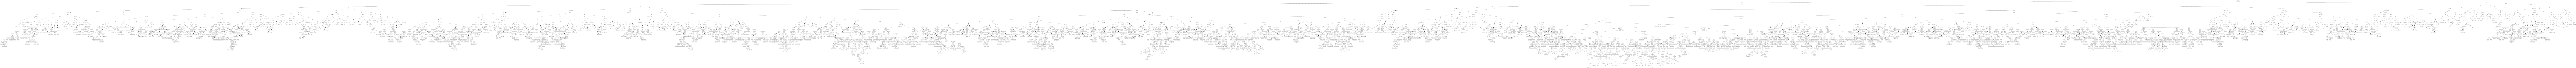

In [26]:
# Generate a visualization of the decision tree
dot_data = export_graphviz(dt, out_file=None, feature_names=dt.feature_names, class_names=dt.target_names)

# Generate decision tree visualization
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [44]:
graph = graphviz.Source(dot_data)
graph #non rendered creates very big object

In [43]:
# Define the hyperparameters to tune (takes about an hour)
param_grid = {'max_depth': np.arange(1, 20),
              'min_samples_split': np.arange(2, 20),
              'min_samples_leaf': np.arange(1, 10)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=10)
grid_search.fit(X, Y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

Best hyperparameters:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 87.75%


In [41]:
# Define the hyperparameters to tune (takes about 7 minutes)
param_grid = {'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(2, 10),
              'min_samples_leaf': np.arange(1, 5)}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=10)
grid_search.fit(X, Y)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: {:.2f}%".format(grid_search.best_score_*100))

Best hyperparameters:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 8}
Best score: 86.70%


In [39]:
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

    Canceled       0.74      0.64      0.68      2431
Not_Canceled       0.83      0.89      0.86      4824

    accuracy                           0.80      7255
   macro avg       0.78      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



__Random Forest__

 ### Modeling and Evaluation 4
 Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

### Modeling and Evaluation 5
Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.
_____________

__MORE DETAIL IS NEEDED ON WHY THIS IS BEST FOR OUR DATASET__

### Modeling and Evaluation 6
Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

### Deployment
How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
_________
__MORE DETAIL IS NEEDED ON WHY THIS IS BEST FOR OUR DATASET__

### Exceptional Work
You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

__Naive Bayes__